# Investigation of neural tangling and LFADS inputs in CST and CO

In this notebook, I'm looking at a few things related to how input-driven the neural dynamics of different tasks are. In particular, I'm most interested in the timing of input processing in motor cortex as the monkey performs CO or CST.

In CO, the monkey holds in place and then gets a cue for which target to reach to. At this point, the neural trajectories should separate into the target-related trajectories. These trajectories look like autonomous dynamics, but at the point of separation, there has to be some input coming into motor cortex to signal which trajectory to start on--at this point, LFADS inputs should be high, and so should tangling. We know that the tangling result is true in the trial averages from the Russo 2018 paper, but it's been hard to see in single trials--which is where LFADS comes in. This is the first thing to check.

The next thing, assuming that bears out at the single trial level, is to examine the timecourse of neural tangling and LFADS inputs during CST. Hypothesis: we might get high tangling when the monkey changes his mind about what he should be doing, e.g. when he's holding still but then decides to move to counteract the cursor movement.

In [1]:
import src
import pyaldata
import yaml
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [2]:
with open('../params.yaml', 'r') as params_file:
    full_params = yaml.safe_load(params_file)
    lfads_params = full_params['lfads_prep']
    analysis_params = full_params['analysis']

co_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=0.5,
)
cst_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=5.0,
)

trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')

td_co = (
    trial_data
    .pipe(src.lfads_helpers.prep_data_with_lfads, 'CO', lfads_params, analysis_params)
    .pipe(pyaldata.add_gradient,'lfads_pca',normalize=True)
    .pipe(pyaldata.add_gradient,'M1_pca',normalize=True)
    .pipe(pyaldata.restrict_to_interval,epoch_fun=co_epoch_fun)
)

td_cst = (
    trial_data
    .pipe(src.lfads_helpers.prep_data_with_lfads,'CST', lfads_params, analysis_params)
    .pipe(pyaldata.add_gradient,'lfads_pca',normalize=True)
    .pipe(pyaldata.add_gradient,'M1_pca',normalize=True)
    .pipe(pyaldata.restrict_to_interval,epoch_fun=cst_epoch_fun)
)

/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/pandas/core/common.py:471: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [  7   8  18  19  22  24  25  33  34  36  56  62  66  86  92  94  95 103
 110 112 115 120 123 131 137 139 146 157 159 161 162 165 173 181 187 200
 218 222 224 225 229 230 237 239 244 249 254 261 266 269 281 286 304 306
 308 309 316 321 334 338 342 344 347 351 352 355 357 360 361 366 370 371
 373 376 378 381 382 384 386 388 393 394 399 403 404 405 408 409 411 413
 416 420 422 423 424 426 427 428 429 431 435 436 437 446 447 452 454 456
 458 459 460 461 462 464 469 472 476 477 481 488 489 490 491 492 494 500
 508 509 510 512 513 516 519 534 535 536]
  return func(obj, *args, **kwargs)
/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/pandas/core/common.py:471: UserWarning: Dropping the trials with the following IDs because of inval

In [3]:
td_co = src.data.add_trial_time(td_co,ref_event='idx_goCueTime')
df_co = src.util.crystallize_dataframe(td_co,sig_guide=['trialtime','M1_pca','dM1_pca','lfads_pca','dlfads_pca','lfads_inputs','rel_hand_pos','hand_vel','cursor_pos','cursor_vel'])
meta_co = src.util.extract_metaframe(td_co,metacols=['trial_id','tgtDir','tgtMag'])
df_co = df_co.join(meta_co,on='trial_id')
co_measures = pd.DataFrame(
    data = {
        'Time from go cue': df_co[('trialtime',0)],
        'Target direction': df_co[('tgtDir','tgtDir')],
        'Target magnitude': df_co[('tgtMag','tgtMag')],
        'X hand position': df_co[('rel_hand_pos',0)],
        'X hand velocity': df_co[('hand_vel',0)],
        'X cursor position': df_co[('cursor_pos',0)],
        'X cursor velocity': df_co[('cursor_vel',0)],
        'LFADS input norm': np.linalg.norm(df_co['lfads_inputs'],axis=1),
        'Smoothed tangling': src.dynamics.estimate_neural_tangling(df_co,x='M1_pca',dx='dM1_pca',num_sample_points=2500),
        'LFADS tangling': src.dynamics.estimate_neural_tangling(df_co,x='lfads_pca',dx='dlfads_pca',num_sample_points=2500),
    },
    index=df_co.index,
)
co_measures

Time from go cue  Target direction  Target magnitude  \
trial_id Time bin                                                         
11       0                    -1.02               0.0              27.5   
         1                    -0.99               0.0              27.5   
         2                    -0.96               0.0              27.5   
         3                    -0.93               0.0              27.5   
         4                    -0.90               0.0              27.5   
...                             ...               ...               ...   
525      45                    0.33              90.0              27.5   
         46                    0.36              90.0              27.5   
         47                    0.39              90.0              27.5   
         48                    0.42              90.0              27.5   
         49                    0.45              90.0              27.5   

                   X hand position  X hand velocity  X cursor position  \
trial_id Time bin                                                        
11       0                5.419277         2.858712          85.419277   
         1                5.401978        -4.131996          85.401978   
         2                5.200802        -9.029546          85.200802   
         3                4.885514       -14.120929          84.885514   
         4                4.219709       -32.719003          84.219709   
...                            ...              ...                ...   
525      45              -3.510860        -0.765854          76.489140   
         46              -3.325862        15.182013          76.674138   
         47              -2.595967        30.209802          77.404033   
         48              -1.753811        23.053620          78.246189   
         49              -1.231865        11.339430          78.768135   

                   X cursor velocity  LFADS input norm  Smoothed tangling  \
trial_id Time bin                                                           
11       0                  2.853743         29.649934         565.740935   
         1                 -4.226248         41.033598         646.516450   
         2                 -9.172401         49.327625         716.162677   
         3                -14.246232         49.044362         646.662328   
         4                -32.630950         43.111274         849.193928   
...                              ...               ...                ...   
525      45                -0.879618        101.472797         287.365233   
         46                15.033671         83.806901         216.771477   
         47                30.154650         71.058030         199.448768   
         48                23.133956         50.826110         271.607807   
         49                11.363523         39.762665         426.106859   

                   LFADS tangling  
trial_id Time bin                  
11       0             386.677474  
         1             410.079285  
         2             434.326927  
         3             503.303266  
         4             507.314744  
...                           ...  
525      45            587.311606  
         46            422.446111  
         47            302.415458  
         48            242.816981  
         49            247.912842  

[7199 rows x 10 columns]

In [4]:
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
df_cst = src.util.crystallize_dataframe(td_cst,sig_guide=['trialtime','M1_pca','dM1_pca','lfads_pca','dlfads_pca','lfads_inputs','rel_hand_pos','hand_vel','rel_cursor_pos','cursor_vel'])
meta_cst = src.util.extract_metaframe(td_cst,metacols=['trial_id','lambda'])
df_cst = df_cst.join(meta_cst,on='trial_id')
cst_measures = pd.DataFrame(
    data = {
        'Time from go cue': df_cst[('trialtime',0)],
        'Lambda': df_cst[('lambda','lambda')],
        'X hand position': df_cst[('rel_hand_pos',0)],
        'X hand velocity': df_cst[('hand_vel',0)],
        'X cursor position': df_cst[('rel_cursor_pos',0)],
        'X cursor velocity': df_cst[('cursor_vel',0)],
        'LFADS input norm': np.linalg.norm(df_cst['lfads_inputs'],axis=1),
        'Smoothed tangling': src.dynamics.estimate_neural_tangling(df_cst,x='M1_pca',dx='dM1_pca',num_sample_points=2500),
        'LFADS tangling': src.dynamics.estimate_neural_tangling(df_cst,x='lfads_pca',dx='dlfads_pca',num_sample_points=2500),
    },
    index=df_cst.index,
)
cst_measures

Time from go cue  Lambda  X hand position  X hand velocity  \
trial_id Time bin                                                               
2        0                    -1.02     1.2         6.011315         0.737993   
         1                    -0.99     1.2         6.074779         3.928236   
         2                    -0.96     1.2         6.224716         4.464001   
         3                    -0.93     1.2         6.276499        -1.602742   
         4                    -0.90     1.2         6.176095        -3.303471   
...                             ...     ...              ...              ...   
529      195                   4.83     2.3       -79.308541         0.318746   
         196                   4.86     2.3       -79.313721        -0.411568   
         197                   4.89     2.3       -79.313743         0.299297   
         198                   4.92     2.3       -79.297328         0.539859   
         199                   4.95     2.3       -79.296945        -0.167750   

                   X cursor position  X cursor velocity  LFADS input norm  \
trial_id Time bin                                                           
2        0                  6.011315           0.702293         22.672126   
         1                  6.074779           3.966265         27.537756   
         2                  6.224716           4.500838         25.164338   
         3                  6.276499          -1.592172         32.072487   
         4                  6.176095          -3.310948         33.851729   
...                              ...                ...               ...   
529      195              -79.308541           0.347790         40.299165   
         196              -79.313721          -0.468818         45.584637   
         197              -79.313743           0.353057         47.695046   
         198              -79.297328           0.596693         46.801520   
         199              -79.296945          -0.169665         46.696290   

                   Smoothed tangling  LFADS tangling  
trial_id Time bin                                     
2        0                618.815807      186.083449  
         1                333.450760      175.550560  
         2                336.256202      173.910422  
         3                694.451121      168.897997  
         4                780.675002      163.490744  
...                              ...             ...  
529      195              151.345462       40.745989  
         196              178.721073       40.716127  
         197              152.734627       40.550087  
         198              128.590148       41.197015  
         199              110.456821       41.110729  

[47798 rows x 9 columns]

In [5]:
# cst_measures_melt = pd.concat(
#     [
#         pd.DataFrame(
#             data = {
#                 'LFADS input norm': np.linalg.norm(df_cst['lfads_inputs'],axis=1),
#                 'X hand position': df_cst[('rel_hand_pos',0)],
#                 'X hand velocity': df_cst[('hand_vel',0)],
#                 'X cursor position': df_cst[('rel_cursor_pos',0)],
#                 'X cursor velocity': df_cst[('cursor_vel',0)],
#             },
#             index=df_cst.index,
#         ).melt(ignore_index=False,var_name='Name',value_name='Signal'),
#         pd.DataFrame(
#             data = {
#                 'Smoothed tangling': src.dynamics.rand_sample_tangling(num_samples=30,data=df_cst,x='M1_pca',dx='dM1_pca',num_sample_points=2500),
#                 'LFADS tangling': src.dynamics.rand_sample_tangling(num_samples=30,data=df_cst,x='lfads_pca',dx='dlfads_pca',num_sample_points=2500),
#             },
#         ).melt(ignore_index=False,var_name='Name',value_name='Signal')
#     ],
#     axis=0,
# )
# cst_measures_melt['Time from go cue'] = df_cst['trialtime'].squeeze().reindex(cst_measures.index)

# trial = cst_measures_melt.groupby('trial_id').get_group(313)
# g = sns.FacetGrid(
#     trial.reset_index(),
#     row='Name',
#     height=2,
#     aspect=4,
#     row_order=['Smoothed tangling','LFADS tangling','LFADS input norm','X hand position'],
#     sharey=False,
# )
# g.map(sns.lineplot,'Time from go cue','Signal')
# 
# for ax in g.axes.flatten():
#     ax.plot([0,0],ax.get_ylim(),'k--')
# 
# sns.despine(fig=g.figure,trim=True)

## CO single trial inspection

Here let's take a look at the single trial CO data, plotting the time course of tangling, LFADS inputs, and behavior. I'll plot the tangling of both the Gaussian smoothed neural data and the LFADS-smoothed neural data as a comparison--it's unlikely that the Gaussian-smoothed tangling will look interpretable, but hopefully the LFADS tangling will, and hopefully it'll match the timing of the LFADS inputs.

In [6]:
from ipywidgets import interact
@interact(co_trial_id=list(df_co.groupby('trial_id').groups.keys()))
def plot_trials(co_trial_id):
    trial = co_measures.groupby('trial_id').get_group(co_trial_id)

    x_vars = ['Time from go cue']
    y_vars = ['Smoothed tangling','LFADS tangling','LFADS input norm','X hand position']
    g=sns.PairGrid(
        trial[x_vars+y_vars],
        y_vars=y_vars,
        x_vars=x_vars,
        height=2,
        aspect=4,
    )

    g.map(sns.lineplot)

    for ax in g.axes.flatten():
        ax.plot([0,0],ax.get_ylim(),'k--')

    sns.despine(fig=g.figure,trim=True)


interactive(children=(Dropdown(description='co_trial_id', options=(11, 16, 17, 23, 40, 45, 47, 58, 59, 65, 69,…

Looks like it does a pretty good job on most trials of recapitulating the intuitions from above. The timing of high tangling generally seems to be just after the go cue, and this matches the LFADS input timing also.

Just for completeness, here's the trial averaged timecourses of all of that (to be clear, this is calculating tangling on single trials and then averaging, rather than the reverse, as in Russo 2018)

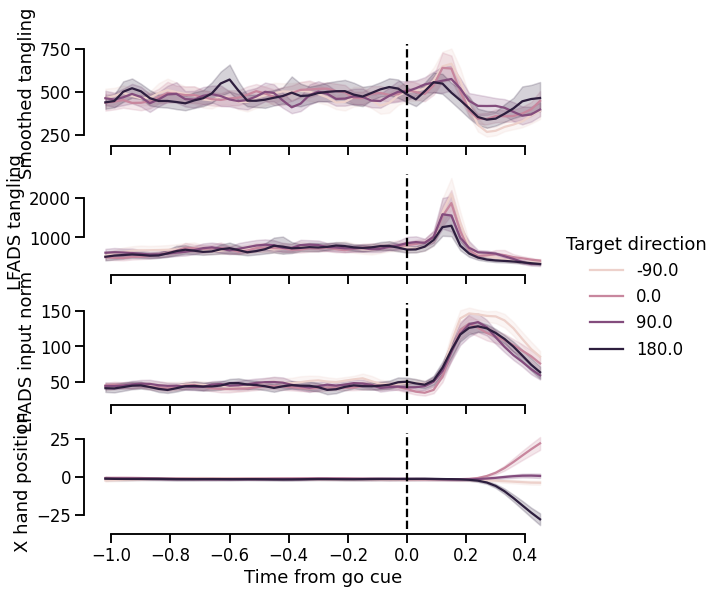

In [7]:
x_vars = ['Time from go cue']
y_vars = ['Smoothed tangling','LFADS tangling','LFADS input norm','X hand position']
hue_var = 'Target direction'
style_var = 'Target magnitude'
g=sns.PairGrid(
    co_measures[x_vars+y_vars+[hue_var,style_var]],
    y_vars=y_vars,
    x_vars=x_vars,
    hue=hue_var,
    height=2,
    aspect=4,
)

g.map(sns.lineplot)
g.add_legend()

for ax in g.axes.flatten():
    ax.plot([0,0],ax.get_ylim(),'k--')

sns.despine(fig=g.figure,trim=True)


Here, it seems like on average, the LFADS tangling is pulling something out that is there in the actual data, but a little bit messier. And it's nice that it matches up with the LFADS inputs, which is a good proof of concept that the LFADS inputs are reasonable.

## CST single trial inspection

Now time to look at CST single trials in the same way.

In [8]:
@interact(cst_trial_id=list(cst_measures.groupby('trial_id').groups.keys()))
def plot_trials(cst_trial_id):
    trial = cst_measures.groupby('trial_id').get_group(cst_trial_id)
    x_vars = ['Time from go cue']
    y_vars = ['LFADS tangling','LFADS input norm','X hand position','X hand velocity']
    g=sns.PairGrid(
        trial[x_vars+y_vars],
        y_vars=y_vars,
        x_vars=x_vars,
        height=2,
        aspect=4,
    )

    g.map(sns.lineplot)

    for ax in g.axes.flatten():
        ax.plot([0,0],ax.get_ylim(),'k--')

    sns.despine(fig=g.figure,trim=True)

interactive(children=(Dropdown(description='cst_trial_id', options=(2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 20, …

Seems like there's something useful in there. First off, tangling and LFADS inputs seem to roughly match up and also seem to be somewhat intermittent. High tangling also sometimes seems to occur just before large movements, and often during what look like holding periods. More investigation on that later...

For completeness again, let's look at the trial averaged values of CST. Here, I don't expect to find much structure, since each trial is structurally different, but possibly there's some overall trend we can see.

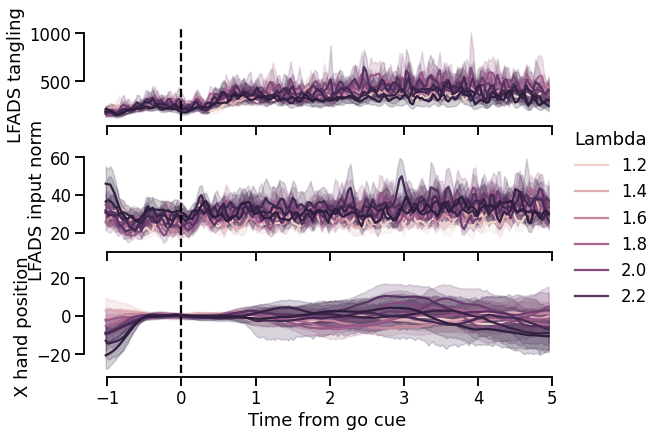

In [9]:
x_vars = ['Time from go cue']
y_vars = ['LFADS tangling','LFADS input norm','X hand position']
hue_var = 'Lambda'
g=sns.PairGrid(
    cst_measures[x_vars+y_vars+[hue_var]],
    y_vars=y_vars,
    x_vars=x_vars,
    hue=hue_var,
    height=2,
    aspect=4,
)

g.map(sns.lineplot)
g.add_legend()

for ax in g.axes.flatten():
    ax.plot([0,0],ax.get_ylim(),'k--')

sns.despine(fig=g.figure,trim=True)

As expected, not a whole lot there, but there is kind of a weird upward trend as the trial goes forward. Perhaps this indicates more input-driven behavior later in the trial? That would make sense, since later in the trial would correspond to larger movements generally.

It's worth comparing neural tangling between CO and CST. Because CST is highly input driven, we might expect that tangling would be higher in CST than in CO.

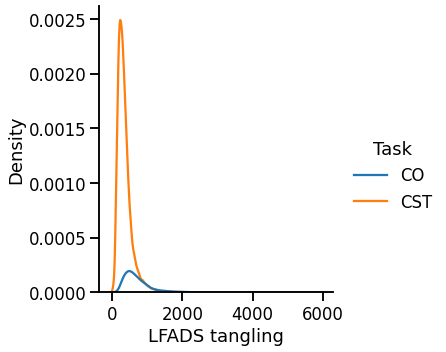

In [10]:
x_vars = ['Time from go cue','LFADS tangling','LFADS input norm','X hand position','X hand velocity']
cocst_tangling = pd.concat(
    [co_measures[x_vars],cst_measures[x_vars]],
    axis=0,
    keys=['CO','CST'],
)
cocst_tangling.index.rename('Task',level=0,inplace=True)
cocst_tangling
sns.displot(
    data=cocst_tangling,
    x='LFADS tangling',
    hue='Task',
    kind='kde',
)

Surprisingly, this seems to not really be the case. I'm not exactly sure why that is, but it's possible that we just can't really compare the two tasks, since they necessitate slightly different tangling calculations.

## Quantification of tangling and LFADS inputs

It seems like tangling and high LFADS input precede large movements, as we might expect from a signal indicating the onset of some intermittent movement or adjustment. Let's try to uncover this relationship (if it's there).

First, let's just verify that tangling and LFADS input norm are highly correlated to start with.

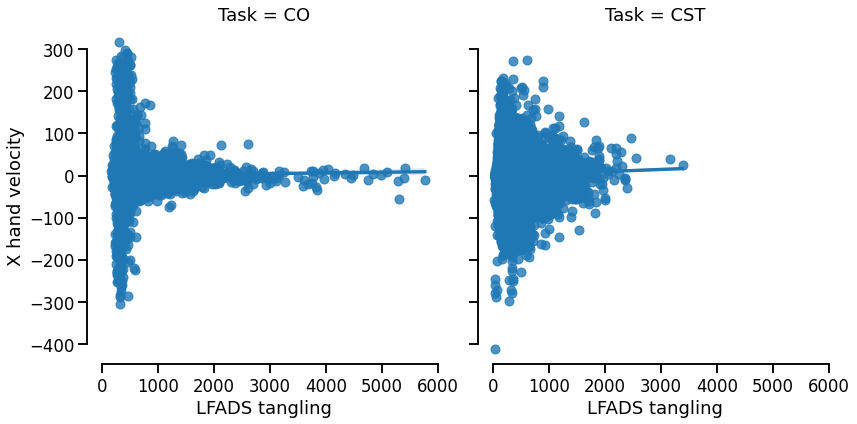

In [20]:
# sns.jointplot(
#     data=cocst_tangling,
#     x='LFADS tangling',
#     y='LFADS input norm',
#     col='Task',
#     kind='reg',
# )
g = sns.FacetGrid(
    data=cocst_tangling.reset_index(),
    col='Task',
    height=6,
    row_order=['CO','CST'],
)
g.map(sns.regplot,'LFADS tangling','LFADS input norm')
sns.despine(fig=g.figure,trim=True)

Hmm... not super convincing on the CO plot, but there does seem to be a bit of a bimodal distribution there. Let's try out a different plot to see if that's the case.

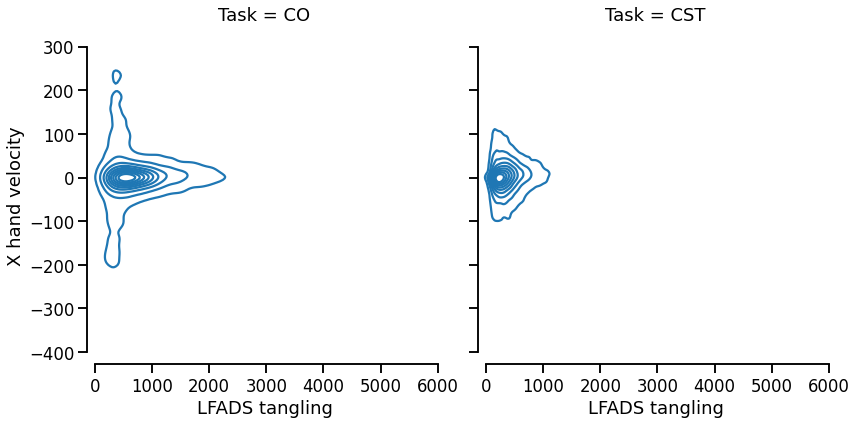

In [21]:
g = sns.FacetGrid(
    data=cocst_tangling.reset_index(),
    col='Task',
    height=6,
    row_order=['CO','CST'],
)
g.map(sns.kdeplot,'LFADS tangling','LFADS input norm')
sns.despine(fig=g.figure,trim=True)

I think there probably is some sort of bimodality in there with high LFADS input but low tangling that's throwing this whole thing off. Without that top lobe, tangling would probably correlate okay with LFADS input. What that top lobe of the distributional plot is, I'm not sure. But it's a problem for another time.

## Cross-correlation between tangling and hand speed

Let's move onto the cross-correlograms between tangling and horizontal hand speed! For this, we'll cross-correlate tangling and hand speed trial-by-trial and then average the cross-correlograms together.

Mechanistically, this involves grouping by `trial_id`, computing the cross-correlogram for each group (which results in its own DataFrame with index `(trial_id, Lag bin)`), and then concatenating all of those together. We can then plot the result using Seaborn pretty easily.

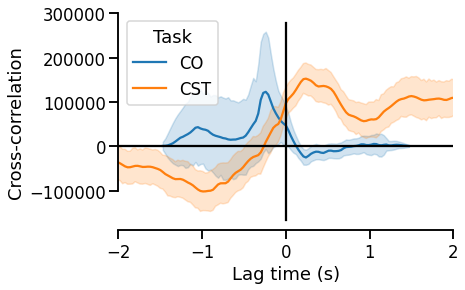

In [19]:
from scipy.signal import correlate, correlation_lags

tangling_vel_corr = (
    cocst_tangling.groupby(['Task','trial_id'])
    .apply(
        lambda s: pd.Series({
            'Cross-correlation': correlate(s['LFADS tangling'],(s['X hand velocity'])),
            'Lag bin': correlation_lags(len(s['LFADS tangling']),len(s['X hand velocity'])),
            'Lag time (s)': correlation_lags(len(s['LFADS tangling']),len(s['X hand velocity']))*analysis_params['bin_size'],
        })
    )
    .explode(column=['Cross-correlation','Lag bin','Lag time (s)'])
    .set_index('Lag bin',append=True)
)

tang_vel_ax = sns.lineplot(
    data=tangling_vel_corr,
    x='Lag time (s)',
    y='Cross-correlation',
    hue='Task',
)

tang_vel_ax.plot(
    [0,0],
    tang_vel_ax.get_ylim(),
    'k-',
)
tang_vel_ax.plot(
    tang_vel_ax.get_xlim(),
    [0,0],
    'k-',
)
tang_vel_ax.set_xlim([-2,2])

sns.despine(ax=tang_vel_ax,trim=True)

Well... I accidentally cross-correlated the tangling with the hand velocity instead of hand speed, and I found something kind of interesting. It seems as though the tangling is negatively correlated with previous hand velocities and positively correlated with future hand velocities (or vice versa--I haven't figured out what positive lag means here yet). I suppose this means that at points of high tangling there's a sharp autocorrelation in the hand velocity signal? Because normally I would expect hand velocity autocorrelation to be quite wide, which would mean that this kind of result shouldn't be happening. But if tangling indicates some sort of change point in hand velocity (i.e. it happens right as monkeys change direction), then maybe this is what I would expect. But only if it indicated monkeys changing direction in a signed way, i.e. acceleration specifically to the right (or left--again, haven't figured out the signs here yet).

Anyway, here's the actual thing I originally wanted to plot:

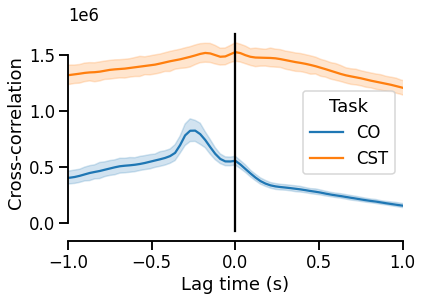

In [14]:
tangling_speed_corr = (
    cocst_tangling.groupby(['Task','trial_id'])
    .apply(
        lambda s: pd.Series({
            'Cross-correlation': correlate(s['LFADS tangling'],np.abs(s['X hand velocity'])),
            'Lag bin': correlation_lags(len(s['LFADS tangling']),len(s['X hand velocity'])),
            'Lag time (s)': correlation_lags(len(s['LFADS tangling']),len(s['X hand velocity']))*analysis_params['bin_size'],
        })
    )
    .explode(column=['Cross-correlation','Lag bin','Lag time (s)'])
    .set_index('Lag bin',append=True)
)

tang_speed_ax = sns.lineplot(
    data=tangling_speed_corr,
    x='Lag time (s)',
    y='Cross-correlation',
    hue='Task',
)
tang_speed_ax.plot(
    [0,0],
    tang_speed_ax.get_ylim(),
    'k-',
)
tang_speed_ax.set_xlim([-1,1])

sns.despine(ax=tang_speed_ax,trim=True)

This seems much more reasonable--a lag somewhere near zero, but probably to one side or the other (haven't looked at the actual location of the max). I would expect the tangling to lead the hand speed somehow.

I guess this means that maybe I should do a cross-correlation with hand acceleration also? Something for the future.

One thing that comes to mind is the fact that cross-correlation has some boundary effects thanks to zero padding on the edges--so if we auto-correlated two constant functions, we would get something with a peak, even though the cross-correlation should be flat. I can try to fix this by implementing a version of cross-correlation that normalizes the value at each lag by the number of points used to calculate it. I can also normalize by the RMS of each signal so that the autocorrelation of each signal would be 1--this should give something more like a Pearson's correlation coefficient.

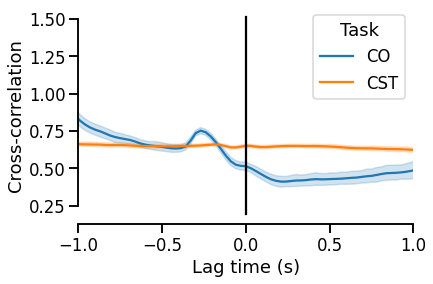

In [15]:
tangling_speed_corr = (
    cocst_tangling.groupby(['Task','trial_id'])
    .apply(
        lambda s: pd.Series({
            'Cross-correlation': src.analysis.normalized_cross_correlation(s['LFADS tangling'],np.abs(s['X hand velocity'])),
            'Lag bin': correlation_lags(len(s['LFADS tangling']),len(s['X hand velocity'])),
            'Lag time (s)': correlation_lags(len(s['LFADS tangling']),len(s['X hand velocity']))*analysis_params['bin_size'],
        })
    )
    .explode(column=['Cross-correlation','Lag bin','Lag time (s)'])
    .set_index('Lag bin',append=True)
)

tang_speed_ax = sns.lineplot(
    data=tangling_speed_corr,
    x='Lag time (s)',
    y='Cross-correlation',
    hue='Task',
)
tang_speed_ax.plot(
    [0,0],
    tang_speed_ax.get_ylim(),
    'k-',
)
tang_speed_ax.set_xlim([-1,1])

sns.despine(ax=tang_speed_ax,trim=True)


Much flatter... And there's a weird upward trend at negative lags for the CO cross-correlation. I'm not sure this makes sense. Maybe there's an issue with the trial structure interfering with the cross-correlation? perhaps it would be better if I concatenated a bunch of trials together. But then the issue is that there will be jumps in the intertrial intervals, which may cause some issues...